In [1]:
import hypothesis as h
from matplotlib import pyplot as plt
import pickle
import numpy as np
from hypothesis.plot import make_square
import hypothesis.plot
from matplotlib import cm
import matplotlib
from itertools import starmap

h.plot.activate()

In [2]:
with open("./computational_overhead.pkl", "rb") as f:
    data = pickle.load(f)

In [3]:
budgets = tuple(sorted(data["nre"]["cpu"].keys()))
n_sampless = tuple(sorted(data["calnre"]["cpu"][budgets[0]].keys()))

In [4]:
cmap = cm.coolwarm
norm = matplotlib.colors.LogNorm(vmin=n_sampless[0], vmax=n_sampless[-1])
colors = [cmap(norm(parameter)) for parameter in n_sampless]

In [5]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=BIGGER_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize

import matplotlib.pylab as pylab

params = {"axes.titlesize": BIGGER_SIZE, "axes.labelpad": 2.0}
pylab.rcParams.update(params)

left = 0.125  # the left side of the subplots of the figure
right = 0.9  # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.9  # the top of the subplots of the figure
wspace = 0.2  # the amount of width reserved for blank space between subplots
hspace = 0.2

/tmp/ipykernel_167038/614360778.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = matplotlib.colorbar.ColorbarBase(
/tmp/ipykernel_167038/614360778.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


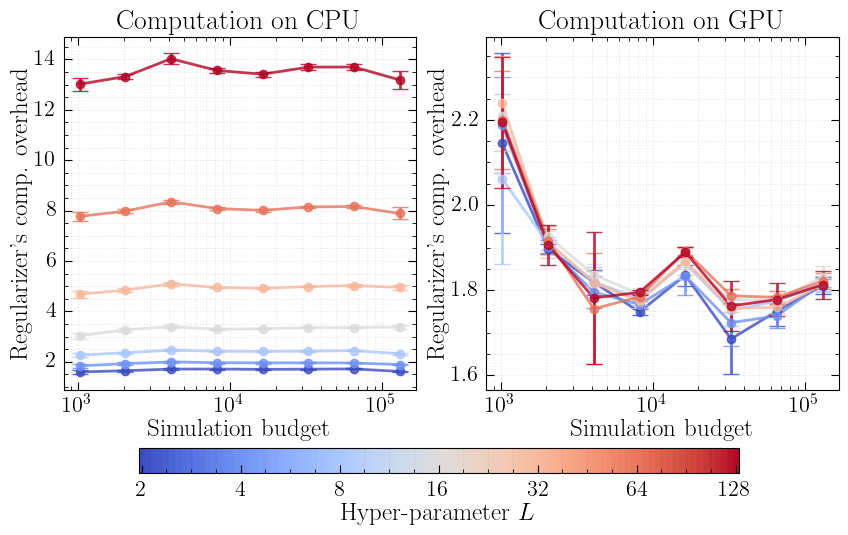

In [6]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
norm_cpu = np.mean(data["nre"]["cpu"][budgets[0]])
norm_gpu = np.mean(data["nre"]["gpu"][budgets[0]])

vanilla = {
    "cpu": tuple(
        map(lambda l: np.mean(l), (data["nre"]["cpu"][b] for b in budgets))
    ),
    "gpu": tuple(
        map(lambda l: np.mean(l), (data["nre"]["gpu"][b] for b in budgets))
    ),
}

n_sampless_colors = []

for ax_idx, device in zip(range(2), ("cpu", "gpu")):
    for idx, n_samples in enumerate(n_sampless):
        cal = tuple(
            map(
                lambda l: np.mean(l),
                (data["calnre"][device][b][n_samples] for b in budgets),
            )
        )
        cal = [c / v for c, v in zip(cal, vanilla[device])]
        cal_std = tuple(
            starmap(
                lambda reg, van: (np.array(reg) / van).std(),
                zip(
                    (data["calnre"][device][b][n_samples] for b in budgets),
                    vanilla[device],
                ),
            )
        )
        (n_sampless_color,) = ax[ax_idx].plot(
            budgets,
            cal,
            c=colors[idx],
            alpha=0.8,
        )
        ax[ax_idx].errorbar(
            budgets,
            cal,
            yerr=cal_std,
            fmt="o",
            color=colors[idx],
            ecolor=colors[idx],
            alpha=0.8,
            capsize=6,
        )

        if device == "gpu":
            n_sampless_colors.append(n_sampless_color)

    ax[ax_idx].set_xlabel("Simulation budget")
    ax[ax_idx].set_ylabel("Regularizer's comp. overhead")
    ax[ax_idx].set_xscale("log")
    ax[ax_idx].set_title(f"Computation on {device.upper()}")
    make_square(ax[ax_idx])

cax = figure.add_axes([0.2, -0.02, 0.6, 0.05])
cax.set_xscale("linear")
fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((-2, 2))
# ticks = np.linspace(0, 1, len(n_sampless))[::3]
ticks = np.linspace(0, 1, len(n_sampless))
cb = matplotlib.colorbar.ColorbarBase(
    cax, cmap=cmap, values=np.linspace(0, 1, 100), orientation="horizontal"
)
cb.set_ticks(ticks)
# cb.set_ticklabels(n_sampless[::3])
cb.set_ticklabels(n_sampless)
cb.set_label(r"Hyper-parameter $L$")
plt.subplots_adjust(
    left=left,
    bottom=bottom,
    right=right,
    top=top,
    wspace=wspace,
    hspace=hspace,
)

figure.savefig("computational_overheaf.pdf", bbox_inches="tight")
figure.show()